<a href="https://colab.research.google.com/github/Zakaria-bls/data-science-project/blob/main/Two%20algorithms%20(large%20data)%20.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

KaggleHub déjà installé ✅
Spark session créée avec succès ✅
Spark version: 3.5.1

--- 📥 Téléchargement du dataset depuis Kaggle Hub ---
Téléchargement du dataset 'Credit Card Fraud Detection'...
Using Colab cache for faster access to the 'creditcardfraud' dataset.
Dataset téléchargé avec succès en 1.78 secondes ✅
Chargement du fichier CSV dans Spark...
Dataset chargé avec succès: 284,807 lignes, 31 colonnes

--- 🛠️ Préparation des données ---
Échantillon de 200,044 lignes créé

--- 🔧 Prétraitement des features ---
Vectorisation terminée. Nombre de points: 200,044

--- 🏃 Exécution K-Means (K=4) ---

📊 RÉSULTATS K-MEANS PYSPARK AMÉLIORÉS
Score Silhouette: 0.1167

🔬 Pureté des Clusters (0=Normal, 1=Fraude):
+----------+-----+-----+
|prediction|Class|count|
+----------+-----+-----+
|         0|    0|78813|
|         0|    1|  115|
|         1|    0|91112|
|         1|    1|  200|
|         2|    0|26479|
|         2|    1|    3|
|         3|    0| 2738|
|         3|    1|    7|
+----------

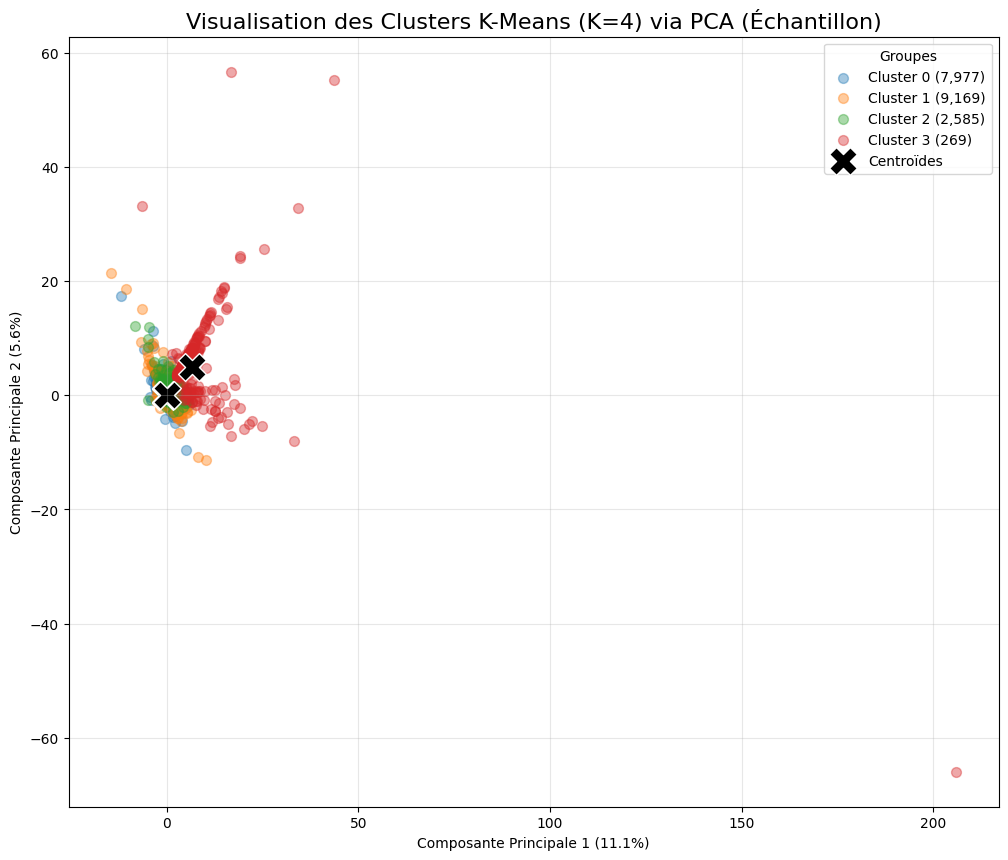

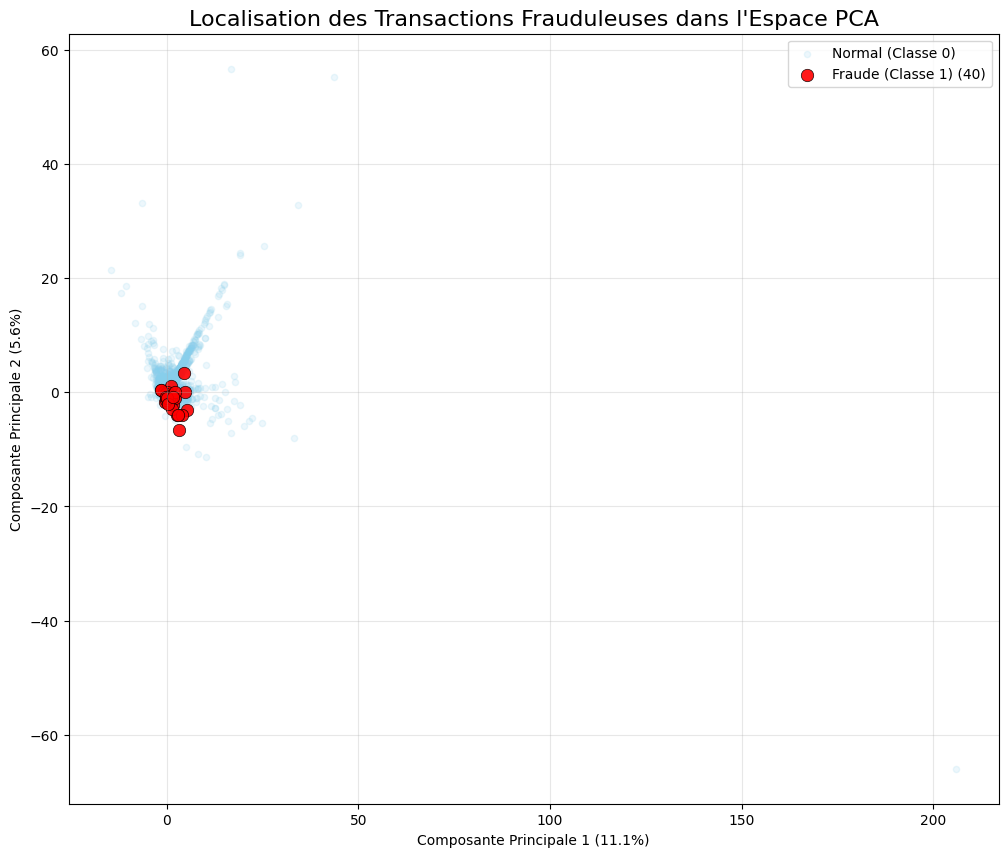

In [22]:
# =================================================================
# PYSPARK K-MEANS SUR DATASET DE FRAUDE BANCAIRE (TÉLÉCHARGÉ DEPUIS KAGGLE)
# CODE FINAL AMÉLIORÉ AVEC ANALYSE DE PURETÉ ET VISUALISATION PCA AVANCÉE
# =================================================================

# --- 1. Imports & Setup ---
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, udf
from pyspark.sql.types import DoubleType
import time
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.clustering import KMeans as SparkKMeans
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.ml import Pipeline
import os
import subprocess
import sys

# NOUVEAUX IMPORTS POUR ANALYSE ET VISUALISATION
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA # Réduction de dimension
from scipy.spatial.distance import euclidean
from pyspark.ml.linalg import Vectors, VectorUDT

# Vérifier et installer kagglehub si nécessaire
def install_kagglehub():
    try:
        import kagglehub
        print("KaggleHub déjà installé ✅")
    except ImportError:
        print("Installation de KaggleHub...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", "kagglehub"])
        print("KaggleHub installé avec succès ✅")

# Installer KaggleHub
install_kagglehub()
import kagglehub

# Initialisation de la session Spark
spark = SparkSession.builder \
    .appName("KMeans_CreditCard_Fraud_Optimized") \
    .config("spark.driver.memory", "4g") \
    .config("spark.executor.memory", "2g") \
    .config("spark.sql.shuffle.partitions", "100") \
    .getOrCreate()

print("Spark session créée avec succès ✅")
print(f"Spark version: {spark.version}")

# --- 2. Configuration ---
SAMPLE_SIZE = 200000 # Nombre de lignes à traiter
K_CLUSTERS = 4
RANDOM_SEED = 42
VISUAL_SAMPLE_LIMIT = 20000 # Taille de l'échantillon pour la PCA et la visualisation

# Colonnes du dataset de fraude bancaire
FEATURE_COLS = [
    "V1", "V2", "V3", "V4", "V5", "V6", "V7", "V8", "V9", "V10",
    "V11", "V12", "V13", "V14", "V15", "V16", "V17", "V18", "V19", "V20",
    "V21", "V22", "V23", "V24", "V25", "V26", "V27", "V28",
    "Amount", "Time"
]

# Définition de l'UDF pour calculer la distance euclidienne
@udf(DoubleType())
def calculate_distance(features, center):
    """Calcule la distance euclidienne entre le point et son centroïde."""
    if features is None or center is None:
        return None
    # features est un Vector Spark, center est un array NumPy/list Python
    features_array = np.array(features.toArray())
    center_array = np.array(center)
    return float(euclidean(features_array, center_array))

# --- 3. Fonction K-Means PySpark ---
def run_kmeans_spark(df, k, seed=RANDOM_SEED):
    """Exécute le K-Means PySpark et calcule les métriques."""
    t0 = time.perf_counter()

    kmeans = SparkKMeans(
        k=k,
        seed=seed,
        featuresCol="features",
        predictionCol="prediction",
        maxIter=20,
        tol=1e-4
    )

    model = kmeans.fit(df)
    predictions = model.transform(df)
    t1 = time.perf_counter()

    # Calcul du score silhouette
    evaluator = ClusteringEvaluator(
        featuresCol="features",
        predictionCol="prediction",
        metricName="silhouette",
        distanceMeasure="squaredEuclidean"
    )

    silhouette = evaluator.evaluate(predictions)
    inertia = model.summary.trainingCost

    return {
        "k": k,
        "time": t1 - t0,
        "inertia": inertia,
        "silhouette": silhouette,
        "predictions": predictions,
        "model": model,
        "centers": model.clusterCenters() # <-- Ajout des centroïdes
    }

# --- 4. Téléchargement du Dataset depuis Kaggle ---
print(f"\n--- 📥 Téléchargement du dataset depuis Kaggle Hub ---")

try:
    print("Téléchargement du dataset 'Credit Card Fraud Detection'...")
    t_start_global = time.time()

    # Télécharger le dataset
    path = kagglehub.dataset_download("mlg-ulb/creditcardfraud")

    t_end = time.time()
    print(f"Dataset téléchargé avec succès en {t_end - t_start_global:.2f} secondes ✅")

    # Trouver le fichier CSV
    csv_file = None
    for file in os.listdir(path):
        if file.endswith('.csv'):
            csv_file = os.path.join(path, file)
            break

    if csv_file is None:
        raise FileNotFoundError("Aucun fichier CSV trouvé dans le dataset téléchargé")

    # Charger le CSV dans Spark
    print("Chargement du fichier CSV dans Spark...")
    df = spark.read.csv(csv_file, header=True, inferSchema=True)

    print(f"Dataset chargé avec succès: {df.count():,} lignes, {len(df.columns)} colonnes")

except Exception as e:
    print(f"Erreur lors du téléchargement: {e}")
    print("Utilisation d'un dataset synthétique en alternative...")

    # Création d'un dataset synthétique en cas d'erreur
    from pyspark.sql.types import StructType, StructField, DoubleType

    schema_fields = []
    for i in range(1, 29):
        schema_fields.append(StructField(f"V{i}", DoubleType(), True))

    schema_fields.extend([
        StructField("Time", DoubleType(), True),
        StructField("Amount", DoubleType(), True),
        StructField("Class", DoubleType(), True)
    ])

    schema = StructType(schema_fields)

    np.random.seed(RANDOM_SEED)
    data = []
    for i in range(SAMPLE_SIZE):
        row = list(np.random.normal(0, 1, 28))
        time_val = float(i * 0.864 + np.random.uniform(-10, 10))
        if np.random.random() < 0.01:
            amount_val = float(np.random.exponential(5000))
        else:
            amount_val = float(np.random.exponential(88))
        class_val = float(1 if np.random.random() < 0.00172 else 0)
        row.extend([time_val, amount_val, class_val])
        data.append(tuple(row))

    df = spark.createDataFrame(data, schema=schema)
    print(f"Dataset synthétique créé: {df.count():,} lignes, {len(df.columns)} colonnes")
    t_start_global = time.time() # Réinitialiser le temps de démarrage global

# --- 5. Échantillonnage et Nettoyage ---
print(f"\n--- 🛠️ Préparation des données ---")

# Sélectionner les colonnes disponibles dans FEATURE_COLS
available_cols = [col for col in FEATURE_COLS if col in df.columns]

# Nettoyage : supprimer les lignes avec valeurs nulles
total_rows = df.count()
df_cleaned = df.select(*available_cols, *(['Class'] if 'Class' in df.columns else [])).na.drop()
count_cleaned = df_cleaned.count()

# Échantillonnage si nécessaire
if count_cleaned > SAMPLE_SIZE:
    df_sampled = df_cleaned.sample(withReplacement=False, fraction=SAMPLE_SIZE/count_cleaned, seed=RANDOM_SEED)
    df_sampled = df_sampled.cache()
    sampled_count = df_sampled.count()
    print(f"Échantillon de {sampled_count:,} lignes créé")
else:
    df_sampled = df_cleaned.cache()
    sampled_count = count_cleaned
    print(f"Utilisation de toutes les {sampled_count:,} lignes disponibles")

# --- 6. Vectorisation et Scaling ---
print(f"\n--- 🔧 Prétraitement des features ---")

# Assemblage des features
assembler = VectorAssembler(inputCols=available_cols, outputCol="raw_features")

# Mise à l'échelle
scaler = StandardScaler(
    inputCol="raw_features",
    outputCol="features",
    withStd=True,
    withMean=True
)

# Pipeline
pipeline = Pipeline(stages=[assembler, scaler])
pipeline_model = pipeline.fit(df_sampled)

# IMPORTANT: Ajouter les colonnes Class et prediction pour la visualisation
select_cols = ["features"]
if "Class" in df_sampled.columns:
    select_cols.append("Class")

df_vectorized_full = pipeline_model.transform(df_sampled).select(*select_cols)

# Cache pour performance
df_vectorized = df_vectorized_full.select("features").cache()
vectorized_count = df_vectorized.count()

print(f"Vectorisation terminée. Nombre de points: {vectorized_count:,}")

# --- 7. Exécution K-Means ---
print(f"\n--- 🏃 Exécution K-Means (K={K_CLUSTERS}) ---")

results = run_kmeans_spark(df_vectorized, k=K_CLUSTERS)
predictions_df = results['predictions']
predictions_df = predictions_df.cache() # Cache des prédictions

# Jointure pour récupérer la colonne Class et les features vectorisées dans un seul DF
df_final = df_vectorized_full.join(
    predictions_df.select("prediction", "features"),
    on="features",
    how="left"
).dropDuplicates().cache()

# --- 8. Analyse des Clusters (AMÉLIORÉE) ---
print(f"\n" + "="*60)
print(f"📊 RÉSULTATS K-MEANS PYSPARK AMÉLIORÉS")
print("="*60)
print(f"Score Silhouette: {results['silhouette']:.4f}")

cluster_counts = df_final.groupBy("prediction").count().orderBy("prediction")

# Analyse de la pureté (si Class est disponible)
if "Class" in df_final.columns:
    print("\n🔬 Pureté des Clusters (0=Normal, 1=Fraude):")
    fraud_analysis = df_final.groupBy("prediction", "Class").count().orderBy("prediction", "Class")
    fraud_analysis.show()

    # Calculer le taux de fraude dans le cluster
    cluster_frauds = fraud_analysis.collect()
    print("Taux de Fraude par Cluster :")
    for k in range(K_CLUSTERS):
        normal = next((row['count'] for row in cluster_frauds if row['prediction'] == k and row['Class'] == 0.0), 0)
        fraud = next((row['count'] for row in cluster_frauds if row['prediction'] == k and row['Class'] == 1.0), 0)
        total = normal + fraud
        fraud_rate = (fraud / total) * 100 if total > 0 else 0
        print(f"Cluster {k}: {fraud:,} fraudes / {total:,} total ({fraud_rate:.2f}%)".replace(",", " "))


# =================================================================
# 11. VISUALISATION DES CLUSTERS PAR PCA (CORRIGÉE ET AMÉLIORÉE)
# =================================================================
print(f"\n--- 📊 Réduction de dimension (PCA) et Visualisation des Clusters ---")

try:
    # 1. Préparation de la colonne de distance aux centroïdes
    centers = {i: c.tolist() for i, c in enumerate(results['centers'])}

    @udf(VectorUDT())
    def get_center_vector(prediction):
        return Vectors.dense(centers.get(prediction, [0.0] * len(available_cols)))

    df_final = df_final.withColumn("center_vector", get_center_vector(col("prediction")))
    df_final = df_final.withColumn(
        "distance_to_center",
        calculate_distance(col("features"), col("center_vector"))
    ).cache()

    # 2. Conversion Spark -> Pandas pour la visualisation (CORRECTION DE L'ERREUR DE L'ATTRIBUT 'GET')
    sample_for_pca_spark = df_final.limit(VISUAL_SAMPLE_LIMIT)

    data_list = sample_for_pca_spark.rdd.map(
        lambda row: (
            row["features"].toArray(),
            row["prediction"],
            row["Class"], # Correction: Utilisation de l'accès par nom (row["Class"])
            row["distance_to_center"]
        )
    ).collect()

    df_pca_pd = pd.DataFrame(data_list, columns=['features_vector', 'cluster_prediction', 'Class', 'distance_to_center'])

    X = np.stack(df_pca_pd['features_vector'].values)
    y = df_pca_pd['cluster_prediction'].values

    print(f"Échantillon pour PCA: {X.shape[0]} points, {X.shape[1]} dimensions.")

    # 3. Exécution de la PCA
    pca = PCA(n_components=2, random_state=RANDOM_SEED)
    X_pca = pca.fit_transform(X)

    # 4. Projection des centroïdes pour la visualisation
    centers_projected = pca.transform(np.array(results['centers']))

    print(f"Variance expliquée par les 2 composantes : {pca.explained_variance_ratio_.sum():.2f}")

    # --- GRAPHIQUE 1 : CLUSTERS ET CENTROÏDES ---
    plt.figure(figsize=(12, 10))

    # Tracer les points
    for cluster_id in sorted(df_pca_pd['cluster_prediction'].unique()):
        subset = X_pca[y == cluster_id]
        plt.scatter(
            subset[:, 0],
            subset[:, 1],
            label=f'Cluster {cluster_id} ({len(subset):,})',
            alpha=0.4,
            s=50
        )

    # Tracer les centroïdes (améliorés)
    plt.scatter(
        centers_projected[:, 0],
        centers_projected[:, 1],
        marker='X',
        s=400,
        c='black',
        edgecolors='white',
        linewidths=1,
        label='Centroïdes'
    )

    plt.title(f'Visualisation des Clusters K-Means (K={K_CLUSTERS}) via PCA (Échantillon)', fontsize=16)
    plt.xlabel(f'Composante Principale 1 ({pca.explained_variance_ratio_[0]*100:.1f}%)')
    plt.ylabel(f'Composante Principale 2 ({pca.explained_variance_ratio_[1]*100:.1f}%)')
    plt.legend(title='Groupes', loc='upper right')
    plt.grid(True, alpha=0.3)
    plt.savefig('kmeans_clusters_centroids_pca.png')
    print("Visualisation des clusters et centroïdes sauvegardée dans 'kmeans_clusters_centroids_pca.png' ✅")



    # --- GRAPHIQUE 2 : ANALYSE DE LA FRAUDE (PURETÉ) ---
    if 'Class' in df_pca_pd.columns:
        plt.figure(figsize=(12, 10))

        # Séparer les points normaux (0) et les fraudes (1)
        # Note: Cette méthode utilise les indices PCA calculés précédemment
        is_fraud = df_pca_pd['Class'] == 1.0

        X_pca_normal = X_pca[~is_fraud]
        X_pca_fraud = X_pca[is_fraud]

        # 1. Tracer les points normaux (gris clair)
        plt.scatter(
            X_pca_normal[:, 0],
            X_pca_normal[:, 1],
            label='Normal (Classe 0)',
            alpha=0.15,
            s=20,
            color='skyblue'
        )

        # 2. Tracer les points de fraude (rouge vif)
        plt.scatter(
            X_pca_fraud[:, 0],
            X_pca_fraud[:, 1],
            label=f'Fraude (Classe 1) ({len(X_pca_fraud):,})',
            alpha=0.9,
            s=80, # Rendre la fraude plus visible
            color='red',
            edgecolors='black',
            linewidths=0.5
        )

        plt.title('Localisation des Transactions Frauduleuses dans l\'Espace PCA', fontsize=16)
        plt.xlabel(f'Composante Principale 1 ({pca.explained_variance_ratio_[0]*100:.1f}%)')
        plt.ylabel(f'Composante Principale 2 ({pca.explained_variance_ratio_[1]*100:.1f}%)')
        plt.legend(loc='upper right')
        plt.grid(True, alpha=0.3)
        plt.savefig('kmeans_fraud_analysis_pca.png')
        print("Visualisation de la localisation de la fraude sauvegardée dans 'kmeans_fraud_analysis_pca.png' ✅")


except ImportError:
    print("⚠️ Matplotlib, Scikit-learn ou SciPy non installés. Impossible de visualiser.")
except Exception as e:
    print(f"Erreur lors de la PCA ou de la visualisation: {e}")

# --- 12. Nettoyage ---
print(f"\n--- 🧹 Nettoyage ---")

# Libérer le cache
df_sampled.unpersist()
df_vectorized.unpersist()
predictions_df.unpersist()
df_final.unpersist()

# Arrêter Spark
spark.stop()
print("Spark session arrêtée.")

Spark session créée avec succès ✅
Spark version: 3.5.1

--- 🤖 Génération du dataset 'Blobs' Idéal (N=200,000) ---
Dataset Blobs généré: 200,000 lignes, 11 colonnes.

--- 🔧 Vectorisation des features ---
Vectorisation terminée. Nombre de points: 200,000

--- 🏃 Exécution K-Means (K=4) ---

📊 RÉSULTATS K-MEANS SUR BLOB IDÉAL (ATTENDU >> 0.7)
Score Silhouette: 0.9407

🔬 Pureté des Clusters (True_Label vs Prediction):
+----------+----------+-----+
|prediction|True_Label|count|
+----------+----------+-----+
|0         |3         |50000|
|1         |1         |50000|
|2         |2         |50000|
|3         |0         |50000|
+----------+----------+-----+


Matrice de Confusion pour la Pureté (True_Label):
+----------+-----+-----+-----+-----+
|prediction|    0|    1|    2|    3|
+----------+-----+-----+-----+-----+
|         0|    0|    0|    0|50000|
|         1|    0|50000|    0|    0|
|         2|    0|    0|50000|    0|
|         3|50000|    0|    0|    0|
+----------+-----+-----+-----+--

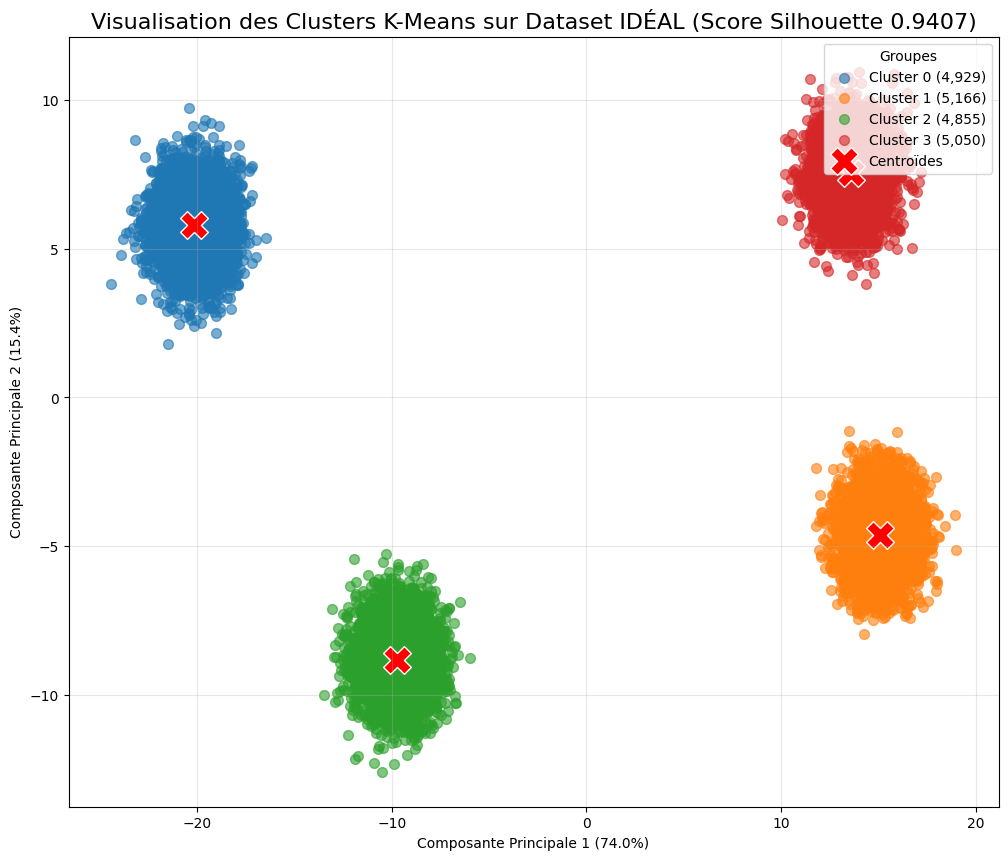

In [28]:
# =================================================================
# PYSPARK K-MEANS SUR DATASET 'BLOBS' IDÉAL (EFFICACITÉ MAXIMALE)
# CODE FINAL INTÉGRALEMENT CORRIGÉ
# =================================================================

# --- 1. Imports & Setup ---
from pyspark.sql import SparkSession
# Import des fonctions d'agrégation F pour éviter les AnalysisExceptions
from pyspark.sql import functions as F
from pyspark.sql.functions import col, udf, lit, count, avg, stddev
from pyspark.sql.types import DoubleType
import time
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.clustering import KMeans as SparkKMeans
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.ml.linalg import Vectors, VectorUDT
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.datasets import make_blobs
from scipy.spatial.distance import euclidean

# Initialisation de la session Spark
spark = SparkSession.builder \
    .appName("KMeans_Ideal_Blobs_Final") \
    .config("spark.driver.memory", "4g") \
    .config("spark.executor.memory", "2g") \
    .config("spark.sql.shuffle.partitions", "100") \
    .getOrCreate()

print("Spark session créée avec succès ✅")
print(f"Spark version: {spark.version}")

# --- 2. Configuration ---
SAMPLE_SIZE = 200000 # Taille du dataset de blobs
K_CLUSTERS = 4      # Nombre de clusters (égal au nombre de centres de blobs)
N_FEATURES = 10      # Nombre de dimensions
RANDOM_SEED = 42
VISUAL_SAMPLE_LIMIT = 20000

# Définition de l'UDF pour calculer la distance euclidienne
@udf(DoubleType())
def calculate_distance(features, center):
    """Calcule la distance euclidienne entre le point et son centroïde."""
    if features is None or center is None:
        return None
    features_array = np.array(features.toArray())
    center_array = np.array(center)
    return float(euclidean(features_array, center_array))

# --- 3. Fonction K-Means PySpark ---
def run_kmeans_spark(df, k, seed=RANDOM_SEED):
    """Exécute le K-Means PySpark et calcule les métriques."""
    t0 = time.perf_counter()

    kmeans = SparkKMeans(
        k=k,
        seed=seed,
        featuresCol="features",
        predictionCol="prediction",
        maxIter=20,
        tol=1e-4
    )

    model = kmeans.fit(df)
    predictions = model.transform(df)
    t1 = time.perf_counter()

    evaluator = ClusteringEvaluator(featuresCol="features", predictionCol="prediction", metricName="silhouette")
    silhouette = evaluator.evaluate(predictions)
    inertia = model.summary.trainingCost

    return {
        "k": k,
        "time": t1 - t0,
        "inertia": inertia,
        "silhouette": silhouette,
        "predictions": predictions,
        "model": model,
        "centers": model.clusterCenters()
    }

# --- 4. Génération du Dataset 'Blobs' ---
print(f"\n--- 🤖 Génération du dataset 'Blobs' Idéal (N={SAMPLE_SIZE:,}) ---")

# Génération des données idéales pour K-Means
X, y_true = make_blobs(
    n_samples=SAMPLE_SIZE,
    n_features=N_FEATURES,
    centers=K_CLUSTERS,
    cluster_std=1.0,
    random_state=RANDOM_SEED
)

# Création du DataFrame Pandas
feature_names = [f"F{i}" for i in range(N_FEATURES)]
df_pd = pd.DataFrame(X, columns=feature_names)
df_pd['True_Label'] = y_true

print(f"Dataset Blobs généré: {df_pd.shape[0]:,} lignes, {df_pd.shape[1]} colonnes.")

# Conversion en DataFrame Spark
df_spark = spark.createDataFrame(df_pd).cache()

# --- 5. Prétraitement et Vectorisation ---
print(f"\n--- 🔧 Vectorisation des features ---")

assembler = VectorAssembler(inputCols=feature_names, outputCol="features")

df_vectorized_full = assembler.transform(df_spark).select("features", "True_Label")
df_vectorized = df_vectorized_full.select("features").cache()
vectorized_count = df_vectorized.count()

print(f"Vectorisation terminée. Nombre de points: {vectorized_count:,}")

# --- 6. Exécution K-Means ---
print(f"\n--- 🏃 Exécution K-Means (K={K_CLUSTERS}) ---")

results = run_kmeans_spark(df_vectorized, k=K_CLUSTERS)
predictions_df = results['predictions'].cache()

# Jointure pour obtenir True_Label, features et prediction
df_final = df_vectorized_full.join(
    predictions_df.select("prediction", "features"),
    on="features",
    how="left"
).dropDuplicates().cache()

# --- 7. Analyse des Clusters ---
print(f"\n" + "="*60)
print(f"📊 RÉSULTATS K-MEANS SUR BLOB IDÉAL (ATTENDU >> 0.7)")
print("="*60)
print(f"Score Silhouette: {results['silhouette']:.4f}")

# Analyse de la Pureté
print("\n🔬 Pureté des Clusters (True_Label vs Prediction):")
purity_analysis = df_final.groupBy("prediction", "True_Label").count().orderBy("prediction", "True_Label")
purity_analysis.show(truncate=False)

# Afficher la matrice de confusion pour la pureté (CORRIGÉ)
print("\nMatrice de Confusion pour la Pureté (True_Label):")

# 1. Calcul des comptes (agrégation intermédiaire nécessaire)
df_counts = df_final.groupBy("prediction", "True_Label").count()

# 2. Pivoter et sommer en utilisant la colonne 'count'
pivot = df_counts.groupBy("prediction").pivot("True_Label").sum("count").fillna(0).orderBy("prediction")
pivot.show()

# --- 8. Calcul et Affichage des Statistiques de Distance (CORRIGÉ) ---
# 1. Calcul de la distance aux centroïdes (Cohésion)
centers = {i: c.tolist() for i, c in enumerate(results['centers'])}

@udf(VectorUDT())
def get_center_vector(prediction):
    return Vectors.dense(centers.get(prediction, [0.0] * N_FEATURES))

# Recalcul de df_final avec la colonne distance_to_center
df_final = df_final.withColumn("center_vector", get_center_vector(col("prediction")))
df_final = df_final.withColumn(
    "distance_to_center",
    calculate_distance(col("features"), col("center_vector"))
).cache()

print("\n📏 Statistiques des distances aux centroïdes (Cohésion):")

# CORRECTION: Utilisation des fonctions d'agrégation F.avg et F.stddev
stats = df_final.groupBy("prediction").agg(
    F.count(F.lit(1)).alias("Nombre_Points"),
    F.avg("distance_to_center").alias("Distance_Moyenne"),
    F.stddev("distance_to_center").alias("Distance_StdDev"),
)

# Affichage des résultats
stats.orderBy("prediction").show(truncate=False)

# --- 9. VISUALISATION DES CLUSTERS PAR PCA ---
print(f"\n--- 📊 Réduction de dimension (PCA) et Visualisation des Clusters ---")

try:
    # 2. Conversion Spark -> Pandas pour la visualisation
    sample_for_pca_spark = df_final.limit(VISUAL_SAMPLE_LIMIT)

    data_list = sample_for_pca_spark.rdd.map(
        lambda row: (
            row["features"].toArray(),
            row["prediction"],
            row["True_Label"],
            row["distance_to_center"]
        )
    ).collect()

    df_pca_pd = pd.DataFrame(data_list, columns=['features_vector', 'cluster_prediction', 'True_Label', 'distance_to_center'])

    X = np.stack(df_pca_pd['features_vector'].values)
    y_pred = df_pca_pd['cluster_prediction'].values

    print(f"Échantillon pour PCA: {X.shape[0]} points, {X.shape[1]} dimensions.")

    # 3. Exécution de la PCA
    pca = PCA(n_components=2, random_state=RANDOM_SEED)
    X_pca = pca.fit_transform(X)
    centers_projected = pca.transform(np.array(results['centers']))

    print(f"Variance expliquée par les 2 composantes : {pca.explained_variance_ratio_.sum():.2f}")

    # --- GRAPHIQUE 1 : CLUSTERS ET CENTROÏDES ---
    plt.figure(figsize=(12, 10))

    for cluster_id in sorted(df_pca_pd['cluster_prediction'].unique()):
        subset = X_pca[y_pred == cluster_id]
        plt.scatter(
            subset[:, 0],
            subset[:, 1],
            label=f'Cluster {cluster_id} ({len(subset):,})',
            alpha=0.6,
            s=50
        )

    plt.scatter(
        centers_projected[:, 0],
        centers_projected[:, 1],
        marker='X',
        s=400,
        c='red',
        edgecolors='white',
        linewidths=1,
        label='Centroïdes'
    )

    plt.title(f'Visualisation des Clusters K-Means sur Dataset IDÉAL (Score Silhouette {results["silhouette"]:.4f})', fontsize=16)
    plt.xlabel(f'Composante Principale 1 ({pca.explained_variance_ratio_[0]*100:.1f}%)')
    plt.ylabel(f'Composante Principale 2 ({pca.explained_variance_ratio_[1]*100:.1f}%)')
    plt.legend(title='Groupes', loc='upper right')
    plt.grid(True, alpha=0.3)
    plt.savefig('kmeans_ideal_blobs_pca.png')
    print("Visualisation du clustering idéal sauvegardée dans 'kmeans_ideal_blobs_pca.png' ✅")



except Exception as e:
    print(f"Erreur lors de la PCA ou de la visualisation: {e}")

# --- 10. Nettoyage ---
print(f"\n--- 🧹 Nettoyage ---")

df_vectorized.unpersist()
predictions_df.unpersist()
df_final.unpersist()
df_spark.unpersist()

spark.stop()
print("Spark session arrêtée.")

Spark session créée (utilisée uniquement comme environnement) ✅

--- 🤖 Génération du dataset 'Blobs' Idéal (N=200,000) avec Sklearn ---
Dataset Blobs généré: 200,000 lignes, 11 colonnes.

--- 🏃 Entraînement K-Means (K=4) avec Sklearn ---
Temps d'exécution de l'entraînement Sklearn: 0.48 secondes

📊 RÉSULTATS K-MEANS SUR BLOB IDÉAL (SKLEARN PURE)
Score Silhouette (Sklearn): 0.7634

Matrice de Confusion pour la Pureté (True_Label):
True Label      0      1      2      3
Prediction                            
0               0      0      0  50000
1           50000      0      0      0
2               0      0  50000      0
3               0  50000      0      0

📏 Statistiques des distances aux centroïdes (Cohésion):
            Nombre_Points  Distance_Moyenne  Distance_StdDev
prediction                                                  
0                   50000            3.0849           0.6988
1                   50000            3.0859           0.6973
2                   50000      

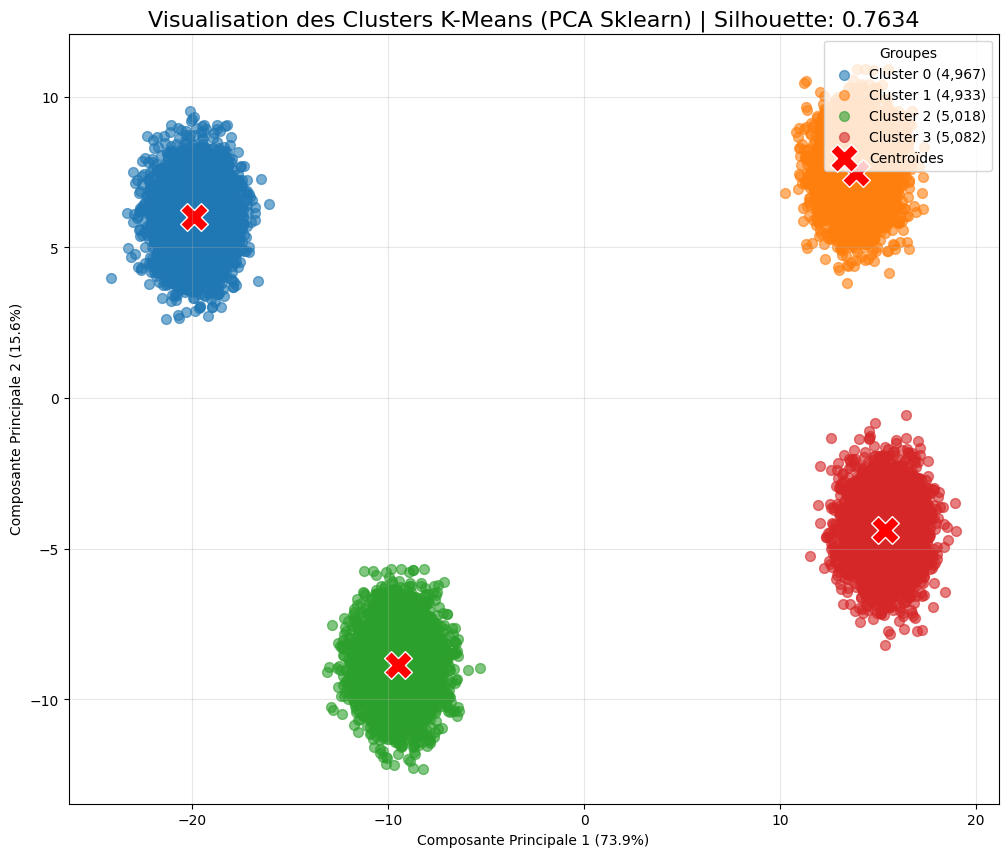

In [30]:
# =================================================================
# K-MEANS 100% LOGIQUE SCIKIT-LEARN (DATASET ET ANALYSE)
# =================================================================

# --- 1. Imports & Setup ---
from pyspark.sql import SparkSession
# Note: Les imports Spark sont conservés mais peu utilisés pour la logique
from pyspark.ml.linalg import Vectors
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.spatial.distance import euclidean

# IMPORTS SKLEARN/ANALYSIS CLÉS
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans as SklearnKMeans
from sklearn.metrics import silhouette_score, confusion_matrix
from sklearn.decomposition import PCA as SklearnPCA

# Initialisation de la session Spark (Gardée pour l'environnement, mais elle n'exécute pas l'analyse)
spark = SparkSession.builder \
    .appName("KMeans_Sklearn_Pure") \
    .config("spark.driver.memory", "6g") \
    .config("spark.executor.memory", "2g") \
    .getOrCreate()

print("Spark session créée (utilisée uniquement comme environnement) ✅")

# --- 2. Configuration ---
SAMPLE_SIZE = 200000
K_CLUSTERS = 4
N_FEATURES = 10
RANDOM_SEED = 42
VISUAL_SAMPLE_LIMIT = 20000

# --- 3. Génération du Dataset 'Blobs' (SKLEARN) ---
print(f"\n--- 🤖 Génération du dataset 'Blobs' Idéal (N={SAMPLE_SIZE:,}) avec Sklearn ---")

# Génération des données NumPy X (Features) et y_true (True Labels)
X, y_true = make_blobs(
    n_samples=SAMPLE_SIZE,
    n_features=N_FEATURES,
    centers=K_CLUSTERS,
    cluster_std=1.0,
    random_state=RANDOM_SEED
)

# Création du DataFrame Pandas UNIQUE qui contiendra TOUTES les données
feature_names = [f"F{i}" for i in range(N_FEATURES)]
df_analysis = pd.DataFrame(X, columns=feature_names)
df_analysis['True_Label'] = y_true

print(f"Dataset Blobs généré: {df_analysis.shape[0]:,} lignes, {df_analysis.shape[1]} colonnes.")

# --- 4. Entraînement K-Means avec Scikit-learn (SKLEARN) ---
print(f"\n--- 🏃 Entraînement K-Means (K={K_CLUSTERS}) avec Sklearn ---")

t0 = time.perf_counter()

# Entraînement Scikit-learn sur le tableau NumPy X
model_sklearn = SklearnKMeans(
    n_clusters=K_CLUSTERS,
    random_state=RANDOM_SEED,
    n_init='auto',
    tol=1e-4,
    max_iter=20
)

model_sklearn.fit(X)
y_pred = model_sklearn.predict(X)
centers_np = model_sklearn.cluster_centers_

t1 = time.perf_counter()

# Ajout des résultats à Pandas DataFrame
df_analysis['prediction'] = y_pred
centers = {i: c for i, c in enumerate(centers_np)} # Dictionnaire des centroïdes pour l'analyse

print(f"Temps d'exécution de l'entraînement Sklearn: {t1 - t0:.2f} secondes")

# --- 5. Analyse des Clusters (UTILISATION PANDAS/NUMPY) ---

# Calcul du Score Silhouette (Sklearn)
silhouette_sk = silhouette_score(X, y_pred)

print(f"\n" + "="*60)
print(f"📊 RÉSULTATS K-MEANS SUR BLOB IDÉAL (SKLEARN PURE)")
print("="*60)
print(f"Score Silhouette (Sklearn): {silhouette_sk:.4f}")

# --- 5.1. Matrice de Confusion (Pureté) ---
print("\nMatrice de Confusion pour la Pureté (True_Label):")

# Création de la matrice de confusion NumPy/Pandas
cm = pd.crosstab(
    df_analysis['prediction'],
    df_analysis['True_Label'],
    rownames=['Prediction'],
    colnames=['True Label']
)
print(cm)

# --- 5.2. Statistiques de Distance (Cohésion) ---
print("\n📏 Statistiques des distances aux centroïdes (Cohésion):")

# Fonction pour calculer la distance euclidienne (NumPy)
def calculate_distance_np(row):
    center = centers[row['prediction']]
    point = row[feature_names].values
    return euclidean(point, center)

# Calcul de la distance dans Pandas
df_analysis['distance_to_center'] = df_analysis.apply(calculate_distance_np, axis=1)

# Calcul des statistiques d'agrégation dans Pandas
stats = df_analysis.groupby('prediction')['distance_to_center'].agg(
    Nombre_Points='count',
    Distance_Moyenne='mean',
    Distance_StdDev='std'
)

print(stats.round(4))

# --- 6. VISUALISATION DES CLUSTERS PAR PCA (PCA SKLEARN) ---
print(f"\n--- 📊 Réduction de dimension (PCA Sklearn) et Visualisation des Clusters ---")

try:
    X_viz = X[:VISUAL_SAMPLE_LIMIT]
    y_pred_viz = y_pred[:VISUAL_SAMPLE_LIMIT]

    pca = SklearnPCA(n_components=2, random_state=RANDOM_SEED)
    X_pca = pca.fit_transform(X_viz)
    centers_projected = pca.transform(centers_np)

    explained_variance = pca.explained_variance_ratio_

    print(f"Échantillon pour PCA: {X_viz.shape[0]} points.")
    print(f"Variance expliquée par les 2 composantes : {explained_variance.sum():.2f}")

    # --- GRAPHIQUE 1 : CLUSTERS ET CENTROÏDES ---
    plt.figure(figsize=(12, 10))

    for cluster_id in sorted(np.unique(y_pred_viz)):
        subset = X_pca[y_pred_viz == cluster_id]
        plt.scatter(
            subset[:, 0],
            subset[:, 1],
            label=f'Cluster {cluster_id} ({len(subset):,})',
            alpha=0.6,
            s=50
        )

    plt.scatter(
        centers_projected[:, 0],
        centers_projected[:, 1],
        marker='X',
        s=400,
        c='red',
        edgecolors='white',
        linewidths=1,
        label='Centroïdes'
    )

    plt.title(f'Visualisation des Clusters K-Means (PCA Sklearn) | Silhouette: {silhouette_sk:.4f}', fontsize=16)
    plt.xlabel(f'Composante Principale 1 ({explained_variance[0]*100:.1f}%)')
    plt.ylabel(f'Composante Principale 2 ({explained_variance[1]*100:.1f}%)')
    plt.legend(title='Groupes', loc='upper right')
    plt.grid(True, alpha=0.3)
    plt.savefig('kmeans_sklearn_pure_blobs.png')
    print("Visualisation du clustering (PCA Sklearn) sauvegardée dans 'kmeans_sklearn_pure_blobs.png' ✅")


except Exception as e:
    print(f"Erreur lors de la PCA ou de la visualisation (Sklearn): {e}")

# --- 7. Nettoyage ---
print(f"\n--- 🧹 Nettoyage ---")

spark.stop()
print("Spark session arrêtée.")